In [1]:
%load_ext autoreload
%autoreload 2

import logging
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hprint as hprint
import defi.dao_cross.supply_demand as ddcrsede
import defi.dao_cross.order as ddacrord

In [2]:
try:
    import pulp
except ImportError:
    !sudo /bin/bash -c "(source /venv/bin/activate; pip install pulp)"
    import pulp
import defi.dao_cross.optimize as ddacropt

     |████████████████████████████████| 14.3 MB 11.4 MB/s eta 0:00:01


In [3]:
hdbg.init_logger(verbosity=logging.DEBUG)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

INFO: > cmd='/venv/lib/python3.8/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-4de13e0d-e2fe-4eb0-b78d-9b0943b45e02.json'
DEBUG Effective logging level=10
DEBUG Shut up 28 modules: matplotlib.colorbar, matplotlib.figure, matplotlib.style.core, matplotlib.pyplot, matplotlib.dviread, matplotlib.mathtext, matplotlib._afm, matplotlib._constrained_layout, matplotlib.lines, matplotlib.axes._axes, matplotlib.axes._base, matplotlib.style, matplotlib.backend_bases, matplotlib._layoutgrid, matplotlib.ticker, matplotlib.gridspec, matplotlib.text, matplotlib, matplotlib.textpath, matplotlib.axis, matplotlib.dates, asyncio, matplotlib.font_manager, matplotlib.axes, matplotlib.texmanager, matplotlib.artist, matplotlib.category, matplotlib.image
DEBUG > (cd . && cd "$(git rev-parse --show-toplevel)/.." && (git rev-parse --is-inside-work-tree | grep -q true)) 2>&1
DEBUG > (git rev-parse --show-toplevel) 2>&1
-----------------------------------------------------------

# Pathological cases

## Get orders and set prices.

In [4]:
type_ = "supply"
supply_quantities = [1, 1, 1, 1]
supply_limit_prices = [1.5, 2, 3, 3.5]
#
supply_orders1 = ddcrsede.get_curve_orders(
    type_, supply_quantities, supply_limit_prices
)
ddacrord.convert_orders_to_dataframe(supply_orders1)

,timestamp,action,quantity,base_token,limit_price,quote_token,deposit_address
0,2023-04-26 15:38:19.582829+00:00,sell,1,BTC,1.5,ETH,3
1,2023-04-26 15:38:19.582921+00:00,sell,1,BTC,2.0,ETH,2
2,2023-04-26 15:38:19.582932+00:00,sell,1,BTC,3.0,ETH,9
3,2023-04-26 15:38:19.582940+00:00,sell,1,BTC,3.5,ETH,4


In [5]:
type_ = "demand"
demand_quantities = [1, 1, 1, 1]
demand_limit_prices = [3.5, 2.5, 2, 1.5]
#
demand_orders1 = ddcrsede.get_curve_orders(
    type_, demand_quantities, demand_limit_prices
)
ddacrord.convert_orders_to_dataframe(demand_orders1)

,timestamp,action,quantity,base_token,limit_price,quote_token,deposit_address
0,2023-04-26 15:38:19.635181+00:00,buy,1,BTC,3.5,ETH,9
1,2023-04-26 15:38:19.635231+00:00,buy,1,BTC,2.5,ETH,1
2,2023-04-26 15:38:19.635242+00:00,buy,1,BTC,2.0,ETH,7
3,2023-04-26 15:38:19.635251+00:00,buy,1,BTC,1.5,ETH,3


In [6]:
prices = {"BTC": 1, "ETH": 2}

## Multiple intersection points at quantity Q'

In [7]:
type_ = "supply"
supply_curve1 = ddcrsede.get_curve_dots(supply_orders1, type_)
supply_curve1

[(0, 1.5),
 (1.0, 1.5),
 (1.0, 2.0),
 (2.0, 2.0),
 (2.0, 3.0),
 (3.0, 3.0),
 (3.0, 3.5),
 (4.0, 3.5),
 (4.0, 4.375)]

In [19]:
type_ = "demand"
demand_curve1 = ddcrsede.get_curve_dots(demand_orders1, type_)
demand_curve1

[(0, 3.5),
 (1.0, 3.5),
 (1.0, 2.5),
 (2.0, 2.5),
 (2.0, 2.0),
 (3.0, 2.0),
 (3.0, 1.5),
 (4.0, 1.5),
 (4.0, 0)]

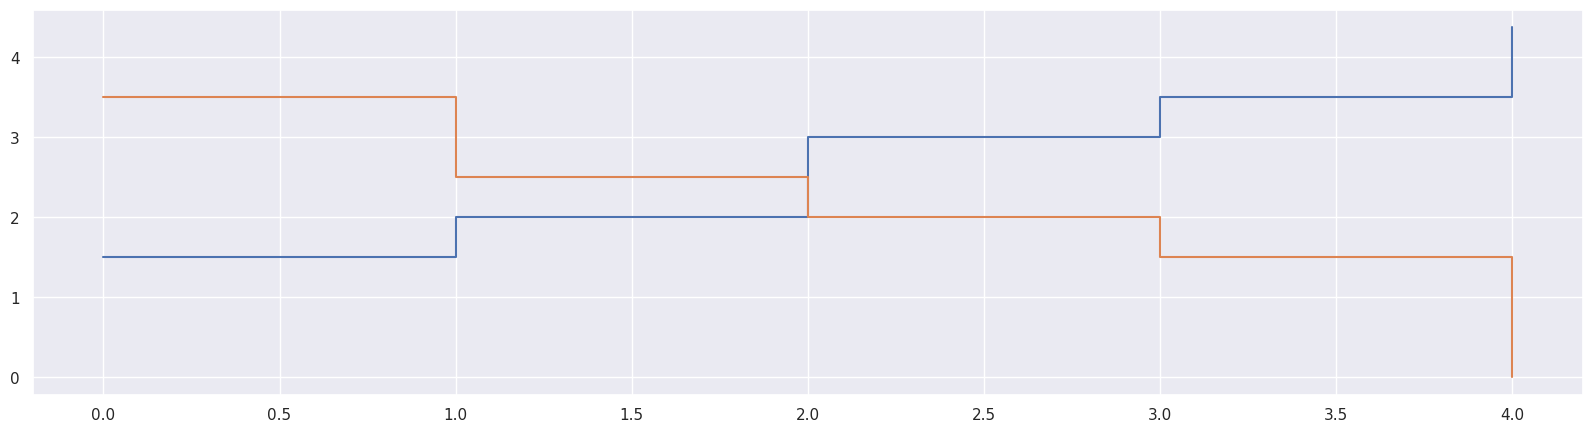

In [20]:
plt.plot(*zip(*supply_curve1))
plt.plot(*zip(*demand_curve1))
plt.show()

In [21]:
all_orders1 = supply_orders1 + demand_orders1
daocross_results1 = ddacropt.run_daocross_solver(all_orders1, prices)
display(daocross_results1)

DEBUG orders=[timestamp=2023-04-26 15:38:19.582829+00:00 action=sell quantity=1.0 base_token=BTC limit_price=1.5 quote_token=ETH deposit_address=3 wallet_address=3, timestamp=2023-04-26 15:38:19.582921+00:00 action=sell quantity=1.0 base_token=BTC limit_price=2.0 quote_token=ETH deposit_address=2 wallet_address=2, timestamp=2023-04-26 15:38:19.582932+00:00 action=sell quantity=1.0 base_token=BTC limit_price=3.0 quote_token=ETH deposit_address=9 wallet_address=9, timestamp=2023-04-26 15:38:19.582940+00:00 action=sell quantity=1.0 base_token=BTC limit_price=3.5 quote_token=ETH deposit_address=4 wallet_address=4, timestamp=2023-04-26 15:38:19.635181+00:00 action=buy quantity=1.0 base_token=BTC limit_price=3.5 quote_token=ETH deposit_address=9 wallet_address=9, timestamp=2023-04-26 15:38:19.635231+00:00 action=buy quantity=1.0 base_token=BTC limit_price=2.5 quote_token=ETH deposit_address=1 wallet_address=1, timestamp=2023-04-26 15:38:19.635242+00:00 action=buy quantity=1.0 base_token=BTC 

/venv/lib/python3.8/site-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


,timestamp,action,quantity,base_token,limit_price,quote_token,deposit_address,q_pi_star,q_tau_star,effective_price
0,2023-04-26 15:38:19.582829+00:00,sell,1,BTC,1.5,ETH,3,1.0,2.0,2.0
1,2023-04-26 15:38:19.582921+00:00,sell,1,BTC,2.0,ETH,2,1.0,2.0,2.0
2,2023-04-26 15:38:19.582932+00:00,sell,1,BTC,3.0,ETH,9,0.0,0.0,NaN
3,2023-04-26 15:38:19.582940+00:00,sell,1,BTC,3.5,ETH,4,0.0,0.0,NaN
4,2023-04-26 15:38:19.635181+00:00,buy,1,BTC,3.5,ETH,9,1.0,2.0,2.0
5,2023-04-26 15:38:19.635231+00:00,buy,1,BTC,2.5,ETH,1,1.0,2.0,2.0
6,2023-04-26 15:38:19.635242+00:00,buy,1,BTC,2.0,ETH,7,0.0,0.0,NaN
7,2023-04-26 15:38:19.635251+00:00,buy,1,BTC,1.5,ETH,3,0.0,0.0,NaN


## Multiple intersection points at price P'

In [22]:
quantity_const = 1.0
type_ = "supply"
supply_orders2 = ddcrsede.get_curve_orders(
    type_,
    supply_quantities,
    supply_limit_prices,
    quantity_const=quantity_const,
)
ddacrord.convert_orders_to_dataframe(supply_orders2)

,timestamp,action,quantity,base_token,limit_price,quote_token,deposit_address
0,2023-04-26 15:39:01.524036+00:00,sell,2,BTC,1.5,ETH,10
1,2023-04-26 15:39:01.524102+00:00,sell,2,BTC,2.0,ETH,5
2,2023-04-26 15:39:01.524112+00:00,sell,2,BTC,3.0,ETH,6
3,2023-04-26 15:39:01.524120+00:00,sell,2,BTC,3.5,ETH,3


In [23]:
type_ = "supply"
supply_curve2 = ddcrsede.get_curve_dots(supply_orders2, type_)
supply_curve2

[(0, 1.5),
 (2.0, 1.5),
 (2.0, 2.0),
 (4.0, 2.0),
 (4.0, 3.0),
 (6.0, 3.0),
 (6.0, 3.5),
 (8.0, 3.5),
 (8.0, 4.375)]

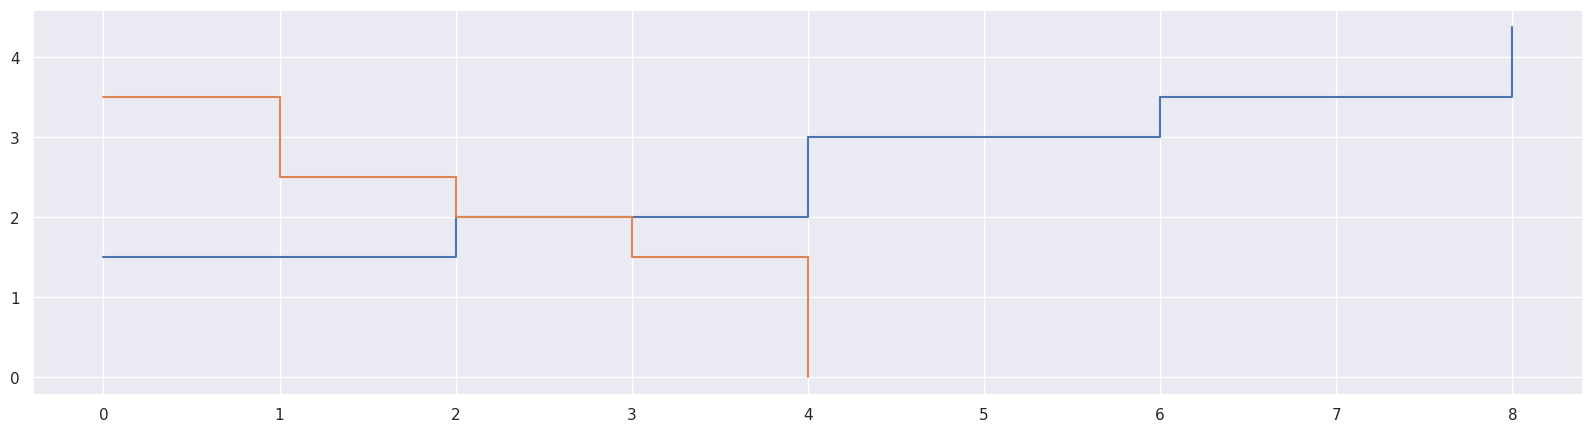

In [24]:
plt.plot(*zip(*supply_curve2))
plt.plot(*zip(*demand_curve1))
plt.show()

In [25]:
all_orders2 = supply_orders2 + demand_orders1
daocross_results2 = ddacropt.run_daocross_solver(all_orders2, prices)
display(daocross_results2)

DEBUG orders=[timestamp=2023-04-26 15:39:01.524036+00:00 action=sell quantity=2.0 base_token=BTC limit_price=1.5 quote_token=ETH deposit_address=10 wallet_address=10, timestamp=2023-04-26 15:39:01.524102+00:00 action=sell quantity=2.0 base_token=BTC limit_price=2.0 quote_token=ETH deposit_address=5 wallet_address=5, timestamp=2023-04-26 15:39:01.524112+00:00 action=sell quantity=2.0 base_token=BTC limit_price=3.0 quote_token=ETH deposit_address=6 wallet_address=6, timestamp=2023-04-26 15:39:01.524120+00:00 action=sell quantity=2.0 base_token=BTC limit_price=3.5 quote_token=ETH deposit_address=3 wallet_address=3, timestamp=2023-04-26 15:38:19.635181+00:00 action=buy quantity=1.0 base_token=BTC limit_price=3.5 quote_token=ETH deposit_address=9 wallet_address=9, timestamp=2023-04-26 15:38:19.635231+00:00 action=buy quantity=1.0 base_token=BTC limit_price=2.5 quote_token=ETH deposit_address=1 wallet_address=1, timestamp=2023-04-26 15:38:19.635242+00:00 action=buy quantity=1.0 base_token=BT

/venv/lib/python3.8/site-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


,timestamp,action,quantity,base_token,limit_price,quote_token,deposit_address,q_pi_star,q_tau_star,effective_price
0,2023-04-26 15:39:01.524036+00:00,sell,2,BTC,1.5,ETH,10,1.0,2.0,2.0
1,2023-04-26 15:39:01.524102+00:00,sell,2,BTC,2.0,ETH,5,2.0,4.0,2.0
2,2023-04-26 15:39:01.524112+00:00,sell,2,BTC,3.0,ETH,6,0.0,0.0,NaN
3,2023-04-26 15:39:01.524120+00:00,sell,2,BTC,3.5,ETH,3,0.0,0.0,NaN
4,2023-04-26 15:38:19.635181+00:00,buy,1,BTC,3.5,ETH,9,1.0,2.0,2.0
5,2023-04-26 15:38:19.635231+00:00,buy,1,BTC,2.5,ETH,1,1.0,2.0,2.0
6,2023-04-26 15:38:19.635242+00:00,buy,1,BTC,2.0,ETH,7,1.0,2.0,2.0
7,2023-04-26 15:38:19.635251+00:00,buy,1,BTC,1.5,ETH,3,0.0,0.0,NaN


## No intersection

In [26]:
limit_price_const = 5.0
supply_orders3 = ddcrsede.get_curve_orders(
    type_,
    supply_quantities,
    supply_limit_prices,
    limit_price_const=limit_price_const,
)
supply_orders3

[timestamp=2023-04-26 15:39:22.019647+00:00 action=sell quantity=1.0 base_token=BTC limit_price=6.5 quote_token=ETH deposit_address=10 wallet_address=10,
 timestamp=2023-04-26 15:39:22.019707+00:00 action=sell quantity=1.0 base_token=BTC limit_price=7.0 quote_token=ETH deposit_address=5 wallet_address=5,
 timestamp=2023-04-26 15:39:22.019717+00:00 action=sell quantity=1.0 base_token=BTC limit_price=8.0 quote_token=ETH deposit_address=8 wallet_address=8,
 timestamp=2023-04-26 15:39:22.019725+00:00 action=sell quantity=1.0 base_token=BTC limit_price=8.5 quote_token=ETH deposit_address=4 wallet_address=4]

In [27]:
type_ = "supply"
supply_curve3 = ddcrsede.get_curve_dots(supply_orders3, type_)
supply_curve3

[(0, 6.5),
 (1.0, 6.5),
 (1.0, 7.0),
 (2.0, 7.0),
 (2.0, 8.0),
 (3.0, 8.0),
 (3.0, 8.5),
 (4.0, 8.5),
 (4.0, 10.625)]

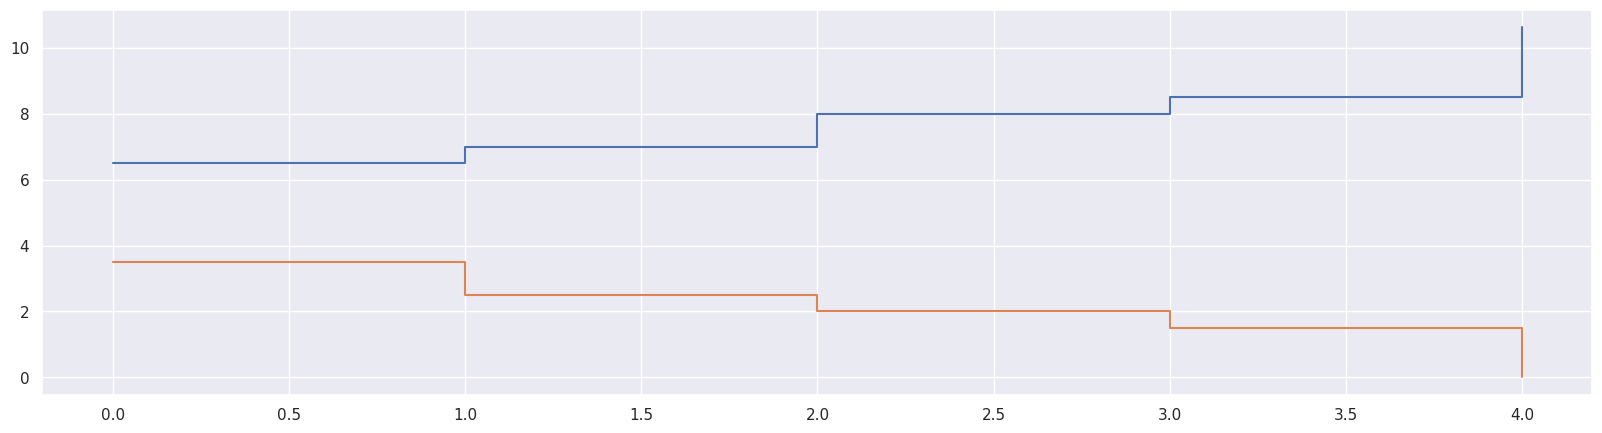

In [28]:
plt.plot(*zip(*supply_curve3))
plt.plot(*zip(*demand_curve1))
plt.show()

In [29]:
all_orders3 = supply_orders3 + demand_orders1
daocross_results3 = ddacropt.run_daocross_solver(all_orders3, prices)
display(daocross_results3)

DEBUG orders=[timestamp=2023-04-26 15:39:22.019647+00:00 action=sell quantity=1.0 base_token=BTC limit_price=6.5 quote_token=ETH deposit_address=10 wallet_address=10, timestamp=2023-04-26 15:39:22.019707+00:00 action=sell quantity=1.0 base_token=BTC limit_price=7.0 quote_token=ETH deposit_address=5 wallet_address=5, timestamp=2023-04-26 15:39:22.019717+00:00 action=sell quantity=1.0 base_token=BTC limit_price=8.0 quote_token=ETH deposit_address=8 wallet_address=8, timestamp=2023-04-26 15:39:22.019725+00:00 action=sell quantity=1.0 base_token=BTC limit_price=8.5 quote_token=ETH deposit_address=4 wallet_address=4, timestamp=2023-04-26 15:38:19.635181+00:00 action=buy quantity=1.0 base_token=BTC limit_price=3.5 quote_token=ETH deposit_address=9 wallet_address=9, timestamp=2023-04-26 15:38:19.635231+00:00 action=buy quantity=1.0 base_token=BTC limit_price=2.5 quote_token=ETH deposit_address=1 wallet_address=1, timestamp=2023-04-26 15:38:19.635242+00:00 action=buy quantity=1.0 base_token=BT

/venv/lib/python3.8/site-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


,timestamp,action,quantity,base_token,limit_price,quote_token,deposit_address,q_pi_star,q_tau_star,effective_price
0,2023-04-26 15:39:22.019647+00:00,sell,1,BTC,6.5,ETH,10,0.0,0.0,NaN
1,2023-04-26 15:39:22.019707+00:00,sell,1,BTC,7.0,ETH,5,0.0,0.0,NaN
2,2023-04-26 15:39:22.019717+00:00,sell,1,BTC,8.0,ETH,8,0.0,0.0,NaN
3,2023-04-26 15:39:22.019725+00:00,sell,1,BTC,8.5,ETH,4,0.0,0.0,NaN
4,2023-04-26 15:38:19.635181+00:00,buy,1,BTC,3.5,ETH,9,0.0,0.0,NaN
5,2023-04-26 15:38:19.635231+00:00,buy,1,BTC,2.5,ETH,1,0.0,0.0,NaN
6,2023-04-26 15:38:19.635242+00:00,buy,1,BTC,2.0,ETH,7,0.0,0.0,NaN
7,2023-04-26 15:38:19.635251+00:00,buy,1,BTC,1.5,ETH,3,0.0,0.0,NaN
